<a href="https://colab.research.google.com/github/prafful-kumar/Unet-Deblur/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

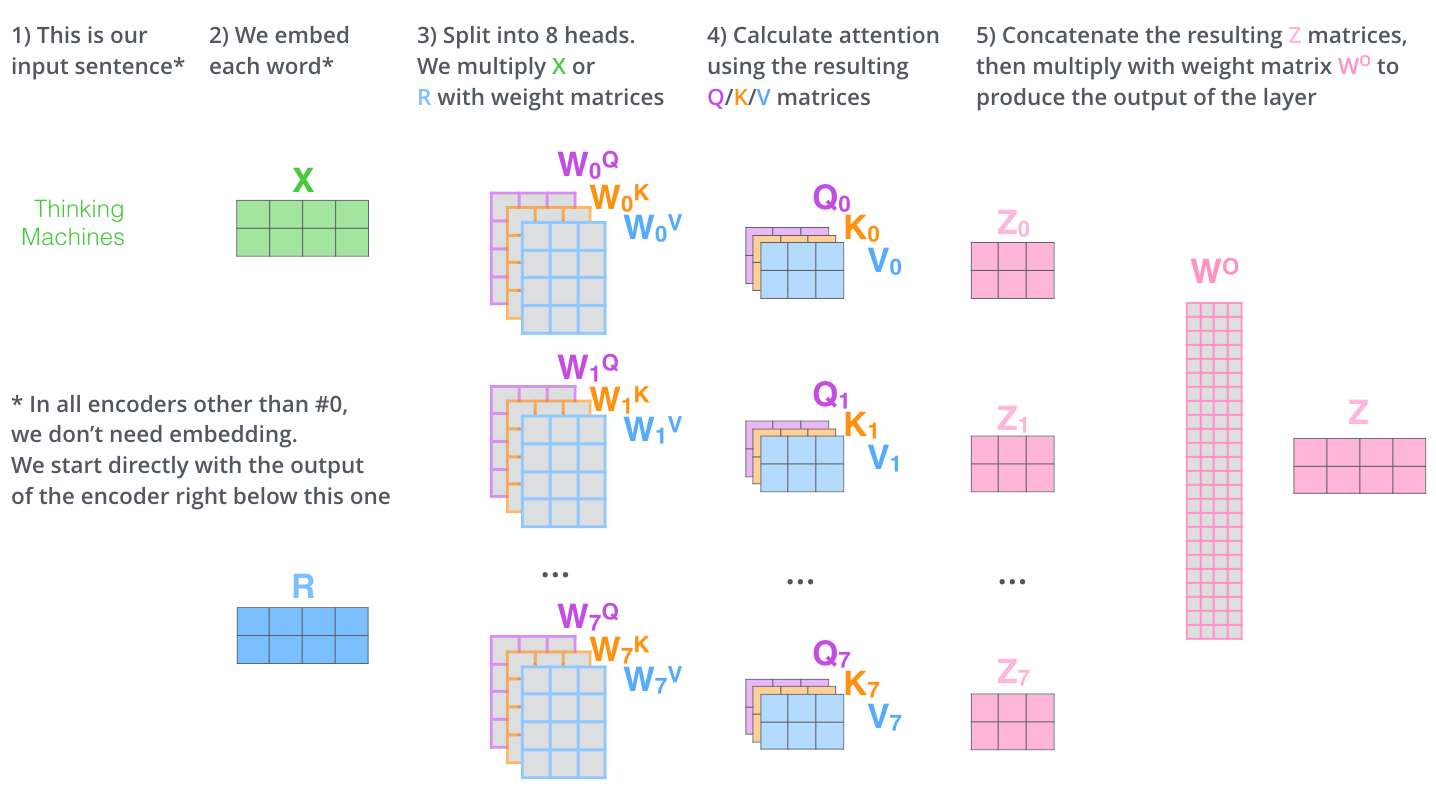

In [ ]:
import torch
import torch.nn as nn

class Self_Attention(nn.Module):
  def __init__(self,embed_size,no_heads): 
    # we will split embedding in 8 parts
    # let suppose we have embedding size of 256 and head = 8, then the output will be 8*32 size
    super(SelfAttention,self).__init__()
    self.embed_size = embed_size
    self.no_heads = no_heads
    self.head_dim = embed_size//no_heads

    assert (self.embed_size == (self.head_dim*self.no_heads)), "Embed size needs to be div by heads"
    # The Python assert keyword tests if a condition is true. If a condition is false, the program will stop with an optional message.

    # Linear Layer for sending value,keys and query.
    # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    # Applies a linear transformation to the incoming data
    self.values = nn.Linear(self.head_dim,self.head_dim,bias = False)
    self.keys = nn.Linear(self.head_dim,self.head_dim,bias = False)
    self.queries = nn.Linear(self.head_dim,self.head_dim,bias = False)
    self.fc_out = nn.Linear(no_heads*self.head_dim, embed_size)

  def forward(self,values,keys,queries,mask):
    N = query.shape[0] # no of training examples we send in at a particular iteration
    value_len, key_len, query_len = values.shape[1], keys.shape[1],queries.shape[1] # their lenth depends on the length of input sentence

    # split embedding into self.no_heads (3rd Image)
    values = values.reshape(N, value_len, self.no_heads,self.head_dim)
    keys = keys.reshape(N, key_len, self.no_heads,self.head_dim)
    queries = queries.reshape(N, queries_len, self.no_heads, self.head_dim)

    # after reshaping we have put it in linear layer
    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)
    
    energy = torch.einsum("nqhd,nkhd->nhqk",[queries,keys])
    # torch.einsum(equation, *operands)
    # queries shape : (N, queries_len, self.no_heads, self.head_dim)
    # keys shape : (N, keys_len, self.no_heads, self.head_dim)
    # energy shape : (N, heads, query_len, key_len)

    if mask is not None:
      energy = energy.masked_fill(mask =0, float("-1e20")) # making mask value minus infinity or very small

    # Apply softmax for attention (Image 4)
    attention = torch.softmax(energy/ (self.embed_size **0.5), dim =3)

    out = torch.einsum("nhql,nlhd->nqhd",[attention, values]).reshape(
        N,query_len,self.no_heads*self.head_dim
    )
    # attention shape : (N,heads,query_len,key_len)
    # values shape : (N, values_len, self.no_heads, self.head_dim)
    # out shape : (N, query_len, no_heads*head_dim) 
    # reshaping bcuz we are concatenating last and 2nd last dim (kind of flattening)  

    out = self.fc_out(out)
    return out


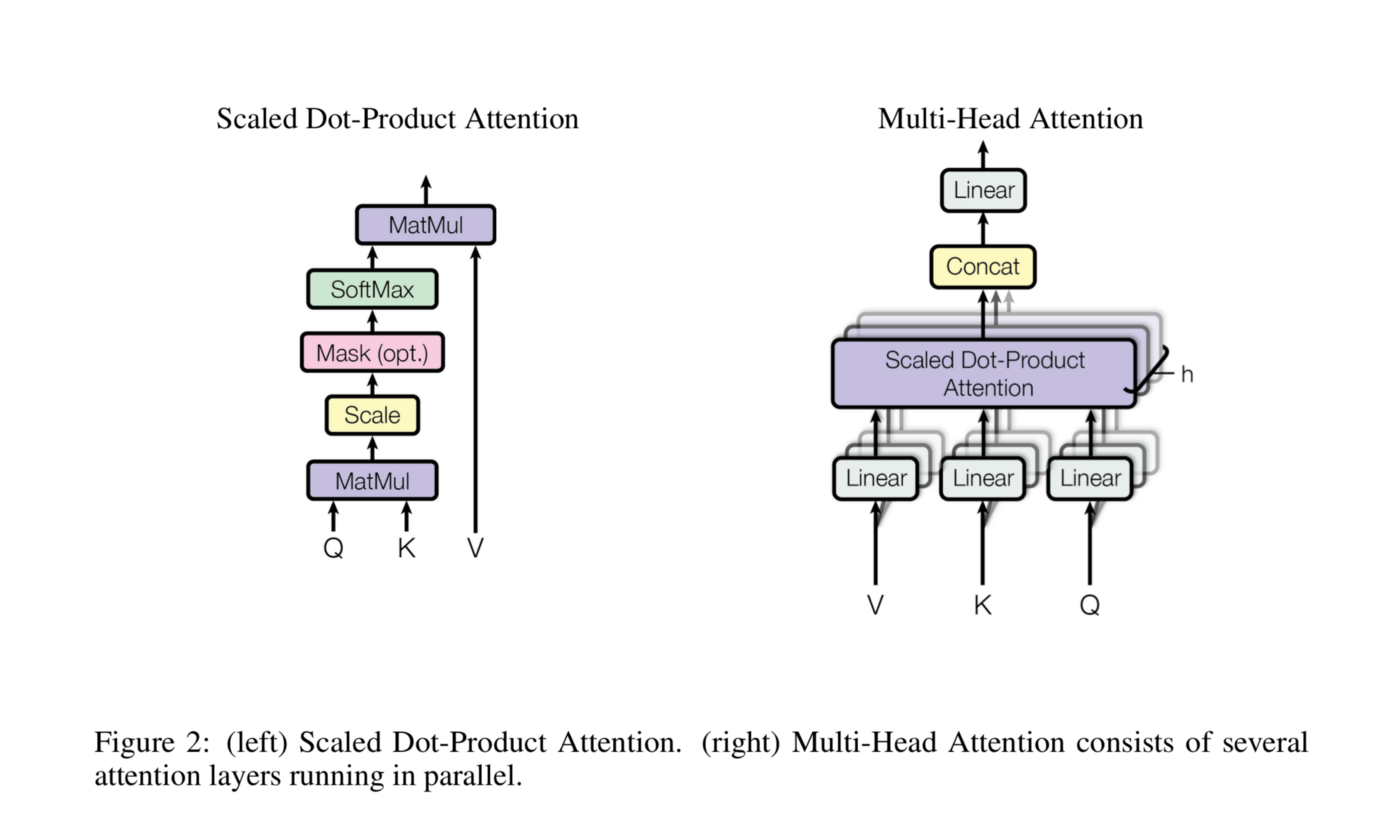

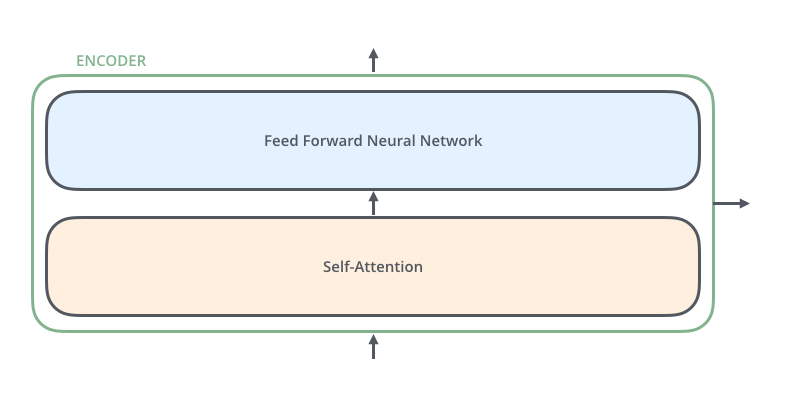Linear Layer for sending value,keys and query.

3rd Image
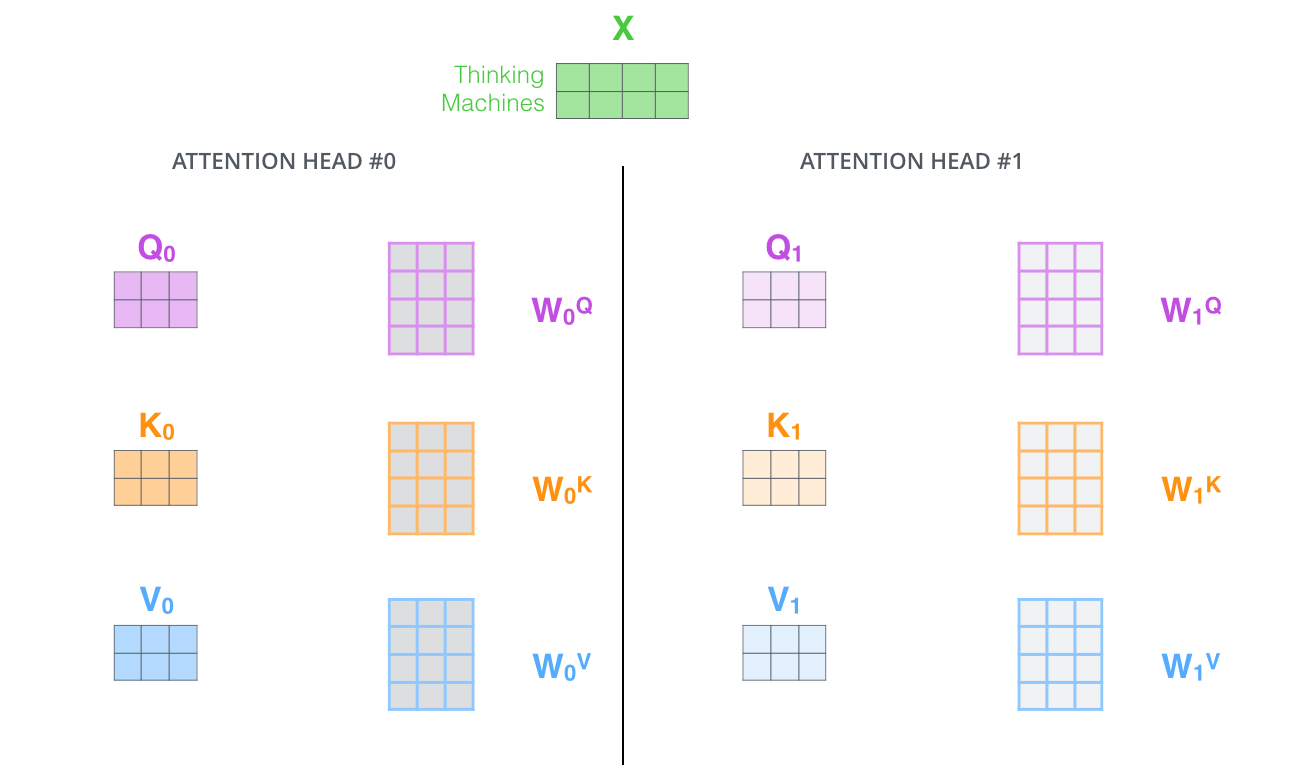

Image 4
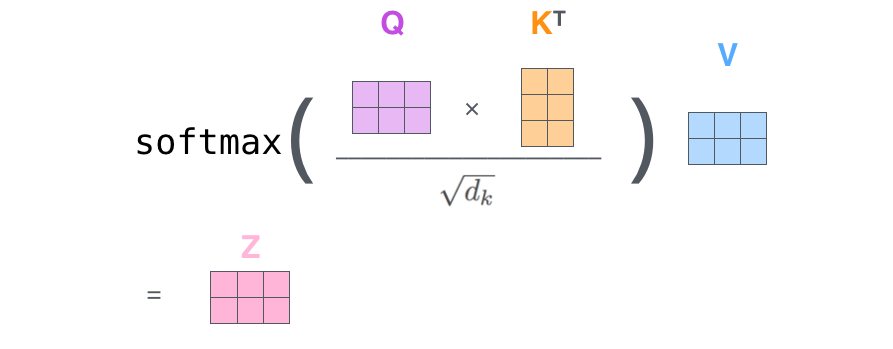

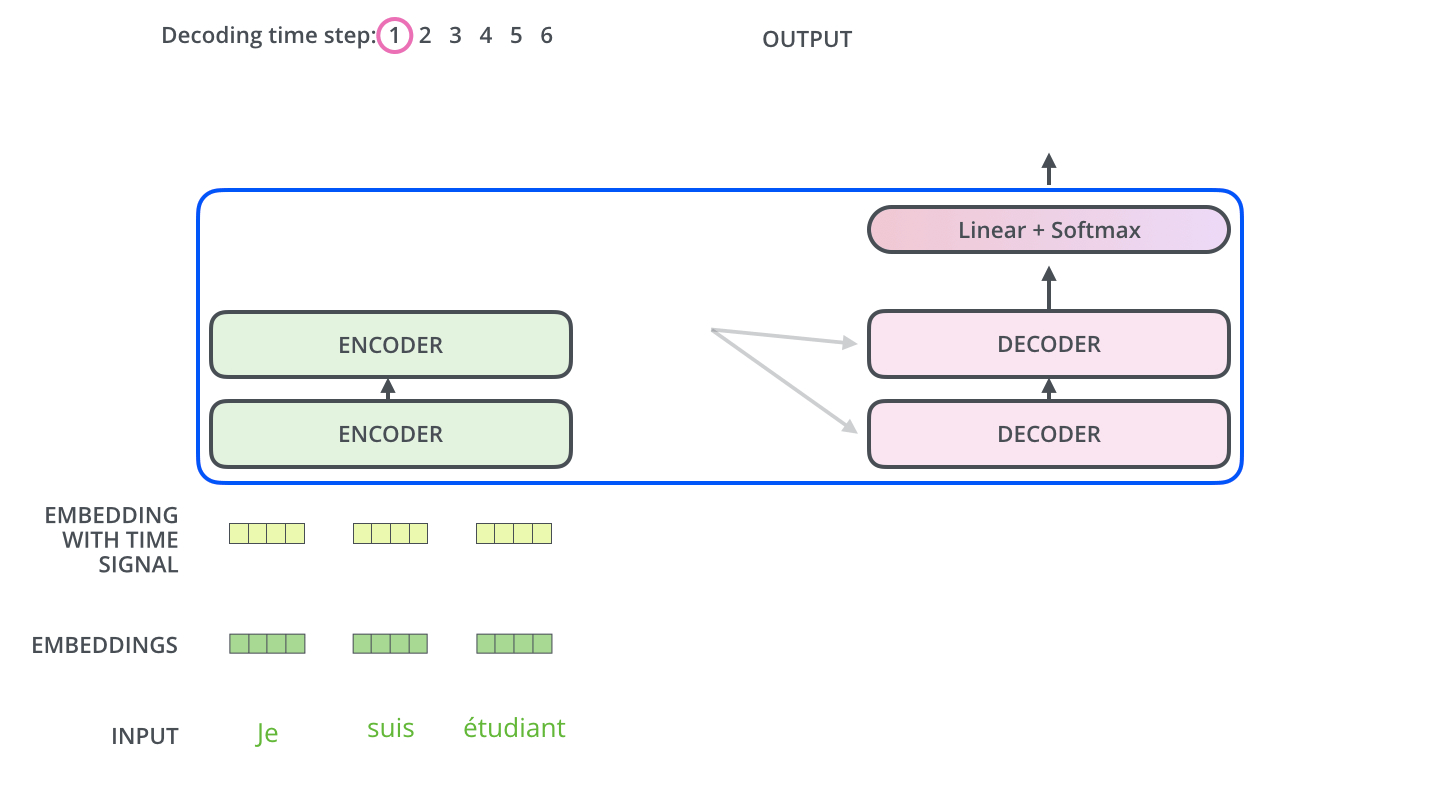

In [ ]:
class Transformer_Block(nn.Module):
  def __init__(self,embed_size,no_heads,dropout, forward_expansion):
    super(Transformer_Block,self).__init__()
    self.attention = Self_Attention(embed_size,no_heads)
    self.norm1 = nn.LayerNorm(embed_size) # Image 5 (Add and normalize layer)
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion*embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size,embed_size)
    )
    # feed_forward is extracting some extra knowledge and then mapping it back to original dim
    self.dropout = nn.Dropout(dropout)

  def forward(self,value,key,query,mask):
    attention = self.attention(value,key,query,mask)
    norm1 = self.norm1(attention + query)
    z = self.dropout(norm1)
    forward = self.feed_forward(z)
    enc = self.norm2(forward + z)
    out = self.dropout(enc)
    return out




Image 5

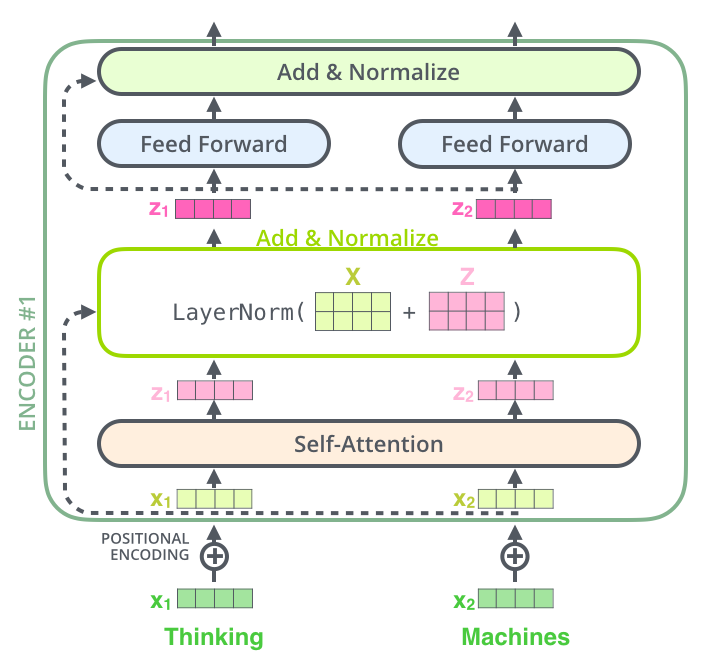

In [ ]:
class Encoder(nn.Module):
  def __init__(self,src_vocab_size,
               embed_size, num_layers,no_heads,
               device,forward_expansion,
               dropout, max_length
               ):
    super(Encoder,self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size,embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList([
                               Transformer_Block(
                                   embed_size,
                                   no_heads,
                                   dropout=dropout,
                                   forward_expansion = forward_expansion,

                               )
                               for _ in range(num_layers)  
    ])
    self.dropout = nn.Dropout(dropout)

  def forward(self,x,mask):
    N,seq_lenght = x.shape # x is the input
    positions = torch.arange(0,seq_length).expand(N, seq_length).to(self.device)

    out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers: 
      # bcuz in encoder key, query and value have same size
      out = layer(out,out,out,mask)

    return out
  

Image 6 
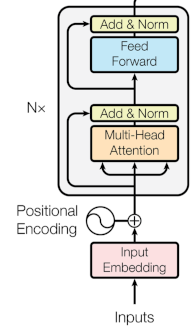

In [ ]:
class Decoder_Block(nn.Module):
  def __init__(self,embed_size,no_heads,
               forward_expansion,dropout,
               device):
    super(Decoder_Block,self).__init__()
    # Image 7
    self.attention = Self_Attention(embed_size,no_heads)
    self.norm = nn.LayerNorm(embed_size)
    self.transformer_block = Transformer_Block(embed_size, no_heads,dropout,
                                               forward_expansion
            )
    self.dropout = nn.Dropout(dropout)

  def forward(self,x,value,key,src_mask,target_mask):
    # source mask is optional, but target mask is necessary
    # target mask is like padding, so that a fixed number of input can go
    # source mask is to prevent unnecessary compute for the once's that are padded

    attention = self.attention(x,x,x,target_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value,key,query,src_mask)
    return out



Image 7 

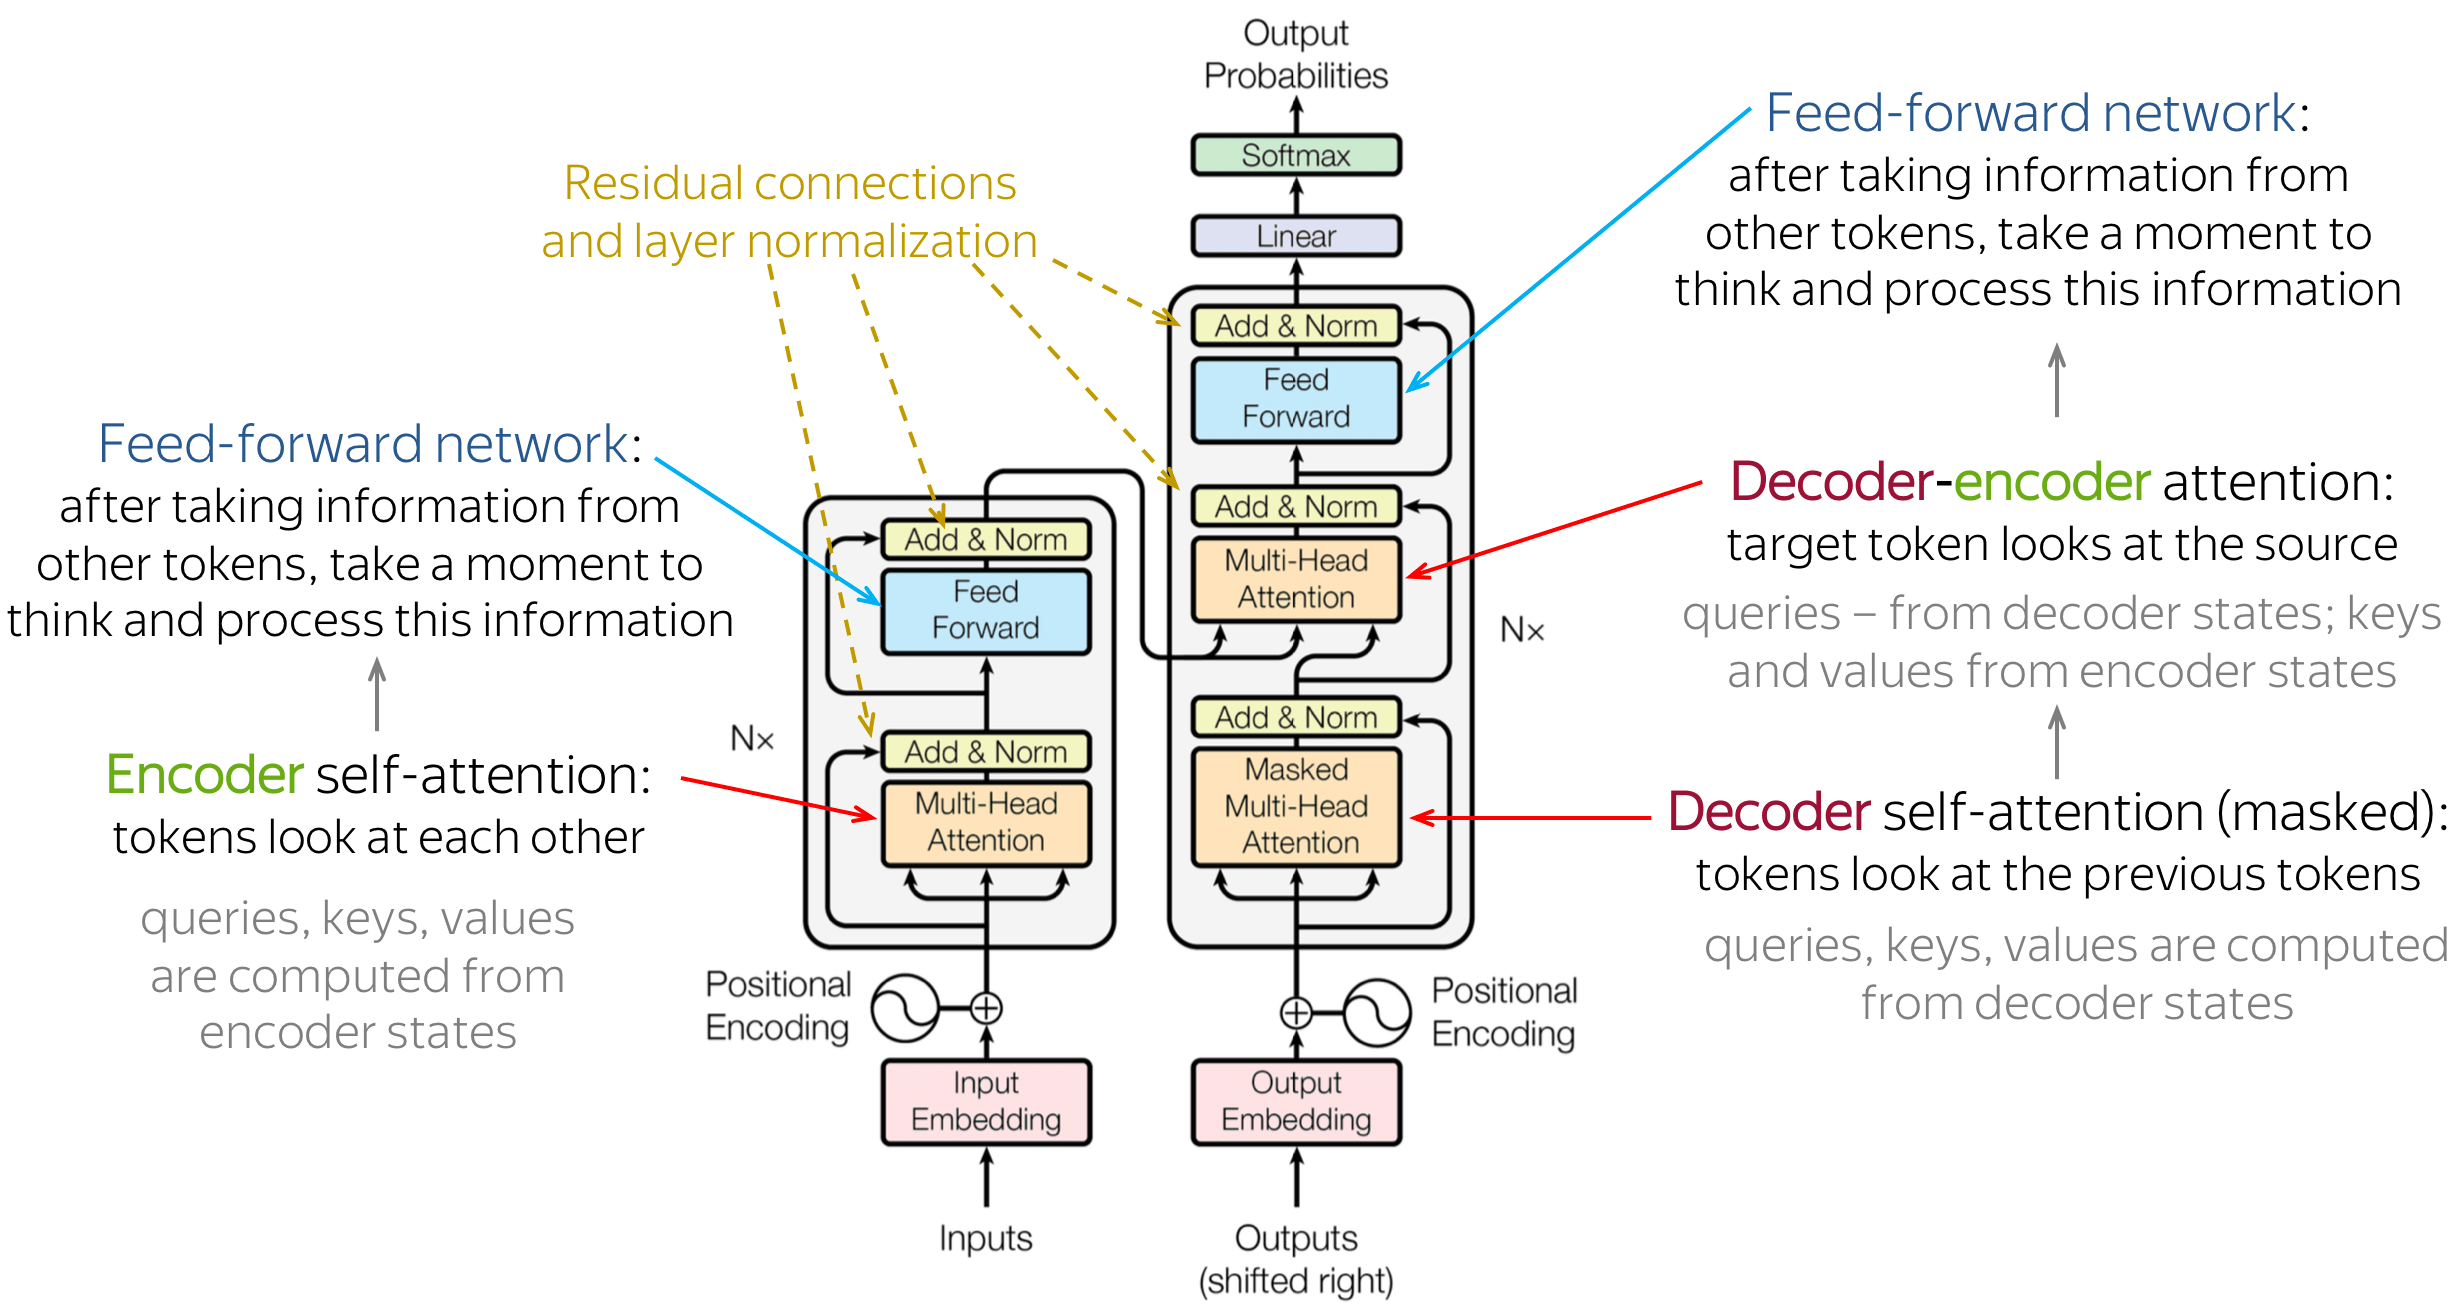

In [ ]:
class Decoder(nn.Module):
  def __init__(self,target_vocab_size,
               embed_size, num_layers,no_heads,
               device,forward_expansion,
               dropout, max_length
               ):
    super(Decoder,self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(target_vocab_size,embed_size) # torch.nn.Embedding(num_embeddings, embedding_dim)
    # A simple lookup table that stores embeddings of a fixed dictionary and size.
    self.position_embedding = nn.Embedding(max_length,embed_size)

    self.layers = nn.ModuleList(
        [Decoder_Block(embed_size,heads, forward_expansion,dropout, device)
        for _ in (num_layers)]
    )

    self.fc_out = nn.Linear(embed_size,target_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x,enc_out,src_mask,target_mask):
    N, seq_length = x.shape
    positions = torch.arange(0,seq_length).expand(N,seq_length).to(self.device)
    x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

    for layer in self.layers:
      x = layer.(x,enc_out,enc_outsrc_mask,target_mask)

    out = self.fc_out(x)
    return out


SyntaxError: ignored

In [ ]:
class Transformer(nn.Module):
  def __init__(self,
               src_vocab_size,
               target_vocab_size,
               src_pad_idx,
               target_pad_idx,
               embed_size = 256,
               num_layers =6,
               forward_expansion = 4,
               no_heads = 8
               dropout=0,
               device = "cuda",
               max_lenght = 100

               ):
    super(Transformer,self).__init__()

    self.encoder = Encoder(
        src_vocab_size,
        embed_size, num_layers,no_heads,
        device,forward_expansion,
        dropout, max_length
    )

    self.decoder = Decoder(
        target_vocab_size,
        embed_size, num_layers,no_heads,
        device,forward_expansion,
        dropout, max_length
    )
    
    self.src_pad_idx = src_pad_idx
    self.target_pad_idx = target_pad_idx
    self.device =device

  def make_src_mask(self,src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    # src_mask : (N,1,1,src_len)
    # if it is a source pad index, then it will be set to zero otherwise to 1
    return src_mask.to(self.device)


  def make_target_mask(self,target):
    N,target_len = target.shape
    target_mask = torch.tril(torch.ones((target_len,target_len))).expand(
        N,1,target_len,target_len
    )

    # tril creates lower triangular matrix 
    # expand it bcuz then we will have one for each training example
    return target_mask.to(self.device)


  def forward(self,src,target):
    src_mask = self.make_src_mask(src)
    target_mask = self.make_target_mask(target)
    enc_src = self.Encoder(src,src_mask)
    out = self.Decoder(target,enc_src,src_mask,target_mask)
    return out



    

SyntaxError: ignored

*The source code and images of this notebook is taken from many sources.